## MVP Know Your Transaction (KYT) - Transaction Risk Classification Engine

### Project Overview

This notebook presents a comprehensive implementation of a Transaction Risk Classification Engine for Anti-Money Laundering (AML) compliance in cryptocurrency transactions. The project addresses the critical need for risk assessment of Bitcoin transactions by combining traditional AML indicators with blockchain-specific risk factors.

### Domain Context: Financial AML for Transactions

#### Core Domain Definition
Anti-Money Laundering (AML) for transactions encompasses the comprehensive framework of laws, regulations, procedures, and technological solutions designed to prevent criminals from disguising illegally obtained funds as legitimate income through the global financial system. This domain includes detection, prevention, and reporting of money laundering, terrorist financing, tax evasion, market manipulation, and misuse of public funds.

### Problem Definition: Transaction Risk Classification Engine

#### Problem Statement
Develop a system that assigns risk classifications to cryptocurrency transactions in real-time, integrating traditional AML indicators with blockchain-specific risk factors including wallet clustering, transaction graph analysis, and counterparty reputation scoring.

#### Technical Requirements
- **Problem Type**: Classification 
- **Processing Speed**: Sub-second analysis for high-frequency transactions
- **Difficulty Level**: High - requires complex multi-dimensional data processing
- **Output Format**: Risk binary classification (illicit = 1 /licit = 2)

#### Data Landscape
The system can processes multiple data dimensions:
- Transaction metadata (amounts, timestamps, fees)
- Wallet addresses and clustering information
- Transaction graph relationships and network topology
- Counterparty databases and reputation scores
- Sanctions lists and regulatory databases
- Temporal patterns and behavioral baselines

### References

This notebook implementation is based on the comprehensive research and analysis conducted during the project development phase. The following reference documents were used in the composition of this initial description:

- **Domain Research**: [current-domain.md](domains/current-domain.md) - Contains detailed market analysis, regulatory framework research, and commercial viability assessment for the Financial AML domain;
- **Problem Analysis**: [current-problem.md](problems/current-problem.md) - Provides comprehensive problem refinement, technical requirements analysis, and solution approach evaluation;
- **Dataset Evaluation**: [current-dataset.md](datasets/current-dataset.md) - Documents dataset selection criteria, suitability scoring, and detailed feature analysis for the Elliptic dataset;
- **Dataset Analysis & Preprocessing**: [dataset-analysis-and-preprocessing.ipynb](datasets/scripts/dataset-analysis-and-preprocessing.ipynb) - Comprehensive Jupyter notebook containing Elliptic dataset download, exploratory data analysis, and ML preparation steps;

These reference documents contain the foundational research that informed the technical approach, feature engineering strategy, and implementation decisions reflected in this notebook.

---

This notebook serves as the primary entry point for the MVP KYT implementation and it can run independently, providing both technical implementation and business context for real cryptocurrency transaction risk assessment.

### Import Libraries

Comprehensive installation and import of all required libraries for machine learning procedures. 

In [1]:
!pip install azure-storage-blob


from pathlib import Path
from azure.storage.blob import BlobServiceClient


"""
Utility functions for dataset processing and Azure blob storage operations.
"""
class AzureBlobDownloader:
    """
    Azure Blob Storage downloader class for managing dataset downloads.

    This class encapsulates Azure blob operations and maintains connection state
    for efficient dataset management operations.
    """

    def __init__(self, account_url, container_name):
        """
        Initialize Azure blob downloader.

        Args:
            account_url (str): Azure storage account URL
            container_name (str): Name of the blob container

        Raises:
            Exception: If connection to Azure fails or Azure SDK not available
        """
        try:
            self.account_url = account_url
            self.container_name = container_name
            self.blob_service_client = BlobServiceClient(account_url=account_url)
            self.container_client = self.blob_service_client.get_container_client(container_name)

        except Exception as e:
            raise Exception(f"Failed to initialize Azure Blob connection: {e}")


    def download_documents(self, project_folder, document_folder, base_path="../"):
        """
        Download dataset from Azure Blob Storage.

        Args:
            dataset_name: Name of the dataset directory in blob storage
            base_path: Local base path for downloads (default: "../")

        Returns:
            bool: True if download successful, False otherwise
        """
        try:
            original_dir = Path(base_path) / project_folder 
            specific_dir = original_dir / document_folder

            original_dir.mkdir(exist_ok=True)
            specific_dir.mkdir(exist_ok=True)

            remote_path = f"{project_folder}/{document_folder}/"
            downloaded_files = 0

            for blob in self.container_client.list_blobs(name_starts_with=remote_path):
                blob_client = self.container_client.get_blob_client(blob.name)
                local_file_path = Path(base_path) / blob.name
                local_file_path.parent.mkdir(parents=True, exist_ok=True)

                blob_data = blob_client.download_blob()
                with open(local_file_path, "wb") as download_file:
                    download_file.write(blob_data.readall())
                downloaded_files += 1

            print(f"Successfully downloaded {downloaded_files} files from Azure Blob Storage")
            return True

        except Exception as e:
            print(f"Failed to download from Azure Blob Storage: {e}")
            return False

In [ ]:
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# Suppress all warnings
warnings.filterwarnings('ignore')

azureClient = AzureBlobDownloader("https://stmvppos.blob.core.windows.net", "mvpkytsup")

### Loading pre-processed datasets

Let's load the pre-processed and compressed data from remote and local sources, the dataset is a composition of cryptocurrency transactions in the Bitcoin blockchain. 

It has 166 feature, which 92 features represent local transaction's information and another 72 features that represent aggregated information from one-hop neighboring transactions (directly linked transactions), thus the dataset has already a curated information about the relationship between transactions. 

That is very important because money laundering and fraud patterns often have coordinated transaction clusters and neighborhood patterns. 

In [3]:
# Define paths
dataset_dir = Path("elliptic_bitcoin_dataset")
root_dir = Path("./datasets")
processed_dir = root_dir / "processed" / dataset_dir
root_dir.mkdir(exist_ok=True)

# Download processed data from Azure if not present locally
if not processed_dir.exists() or not any(processed_dir.iterdir()):
    print(f"Local processed directory is empty. Downloading from Azure...")
    azureClient.download_documents("datasets/processed", dataset_dir.name, base_path="./")

# The complete dataset already pre-processed 
df_complete = pd.read_hdf(processed_dir / "df_complete.h5", key="df_complete")
print(f"Loaded from HDF5: {df_complete.shape} - All subsequent operations will use compressed data")

# The filtered labeled dataset already pre-processed
df_labeled = pd.read_hdf(processed_dir / "df_labeled.h5", key="df_labeled")
print(f"Loaded from HDF5: {df_labeled.shape} - All subsequent operations will use compressed data")

# The filtered unlabeled dataset already pre-processed
df_unlabeled = pd.read_hdf(processed_dir / "df_unlabeled.h5", key="df_unlabeled")
print(f"Loaded from HDF5: {df_unlabeled.shape} - All subsequent operations will use compressed data")

# The edges dataset that maps relationships between transaction nodes
df_edges = pd.read_hdf(processed_dir / "df_edges.h5", key="df_edges")
print(f"Loaded from HDF5: {df_edges.shape} - All subsequent operations will use compressed data")

# Summary of all datasets
print(f"\n📊 Dataset Summary:")
print(f"  - Features: {df_complete.shape[0]:,} transactions × {df_complete.shape[1] -2} features")
print(f"  - Labeled: {df_labeled.shape[0]:,} transactions")
print(f"  - Unlabeled: {df_unlabeled.shape[0]:,} transactions")
print(f"  - Edges: {df_edges.shape[0]:,} transaction relationships")

Loaded from HDF5: (203769, 168) - All subsequent operations will use compressed data
Loaded from HDF5: (46564, 168) - All subsequent operations will use compressed data
Loaded from HDF5: (157205, 168) - All subsequent operations will use compressed data
Loaded from HDF5: (234355, 2) - All subsequent operations will use compressed data

📊 Dataset Summary:
  - Features: 203,769 transactions × 166 features
  - Labeled: 46,564 transactions
  - Unlabeled: 157,205 transactions
  - Edges: 234,355 transaction relationships


### Machine Learning Strategy

Let's apply the machine learning technics to the labeled dataset's portion using supervised learning, and apply the prediction to the unknown unlabeled dataset's portion in order to have a performance base line for future improvements.

Following the steps:

1. Define overall parameters and make data splits;
2. Defining all training models to be used;
3. Defining all pipelines to be used during training;
4. Defining model parameters distribution for a grid search approach;
5. Defining the score function to be used during training;
6. Execute the training;
7. Save all resulting models;
8. Validate all models and select the best models;
9. Use best models to predict unknown data;


**1.Define overall parameters and make data splits**

After spliting the labeled dataset into the train and validation (test) sets, let`s prepare the training dataset for training and validation using the stratified approach, that generates a fixed amount of splits (folds) to the dataset following a fixed proportion of train/test samples. 

The main idea of this approach is to guarantee a training without bias to a specific dataset split because it will maintain the same class proportion for each split (fold) generated. We use this technic in labeled and supervised learning, assuming that the dataset's pattern does not have a significant change over time.

In this specific dataset we take in consideration the timestamp as a grouping factor to transactions but not a changing factor to dataset's pattern over time.

In [4]:
# Defining overall parameters
random_seed = 4354 # PARAMETER: random seed
test_size_split = 0.20 # PARAMETER: test set size
n_stratified_splits = 2 # PARAMETER: number of folds
n_pca_components = 0.95 # PARAMETER: PCA components to keep

np.random.seed(random_seed)

# Prepare data 
x_labeled = df_labeled.drop(['class', 'txId'], axis=1)
y_labeled = df_labeled['class']  # Binary target

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(x_labeled, y_labeled,
    test_size=test_size_split, 
    shuffle=True, 
    random_state=random_seed, 
    stratify=y_labeled) # stratified holdout

# Cross-validation setup to be applied in the training set 
cv = StratifiedKFold(n_splits=n_stratified_splits, 
                     shuffle=True, 
                     random_state=random_seed)

**2. Defining all training models to be used**

Let's define which models to use during training, selecting diverse ML algorithms covering linear, tree-based, probabilistic, and ensemble methods. 

Different algorithms capture different transaction patterns; ensemble methods reduce overfitting risk and can improve individual model performance.

In [5]:
# Defining the individual models
reg = ('LR', LogisticRegression())
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
nav = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Defining ensemble models
bagging = ('Bag', BaggingClassifier())
forest = ('RF', RandomForestClassifier())
extra = ('ET', ExtraTreesClassifier())
ada = ('Ada', AdaBoostClassifier())
gradient = ('GB', GradientBoostingClassifier())

**3. Defining all pipelines to be used during training**

Let's define which ML pipelines to use during training, by configuring which pre-processing operations and models will be used in the training process, also pipelines helps to avoid data leakage by letting the feature transformation be applied only in the training dataset portion.          

For feature transformation the standard scaler was used to ensure the best scale for feature values, by normalizing all values to a common metric it reduce the bias to feature magnitude, and enable the consecutive operations to capture the important patterns between features without being influenced mainly by their magnitude, all features contribute equally to pattern detection. That is specially important in finance because the difference between feature scales can be significant.

For feature dimensionality reduction, the Principal Component Analysis (PCA) was used to reduce from 166 to only 46 features, we are aiming to reduce the feature dimensionality at the same time as maximizing the dissimilarity of the original dataset, thus extracting the most discriminative features and improving the model training performance. It must be applied after the standard scaler to avoid the mentioned magnitude bias, and in datasets that has a great quantity of features. 

In [6]:
# Creating the pipelines
pipelines = []
std  = ('std', StandardScaler())  # Standardization
pca = ('pca', PCA(n_components=n_pca_components))  # Feature reduction

# Defining the pipelines, for future experimentation 
#pipelines.append(('LR', Pipeline([std, pca, reg]))) Commented out due to poor performance 
#pipelines.append(('NB', Pipeline([std, pca, nav]))) Commented out due to poor performance 
pipelines.append(('KNN', Pipeline([std, pca, knn])))
pipelines.append(('CART', Pipeline([std, pca, cart])))
pipelines.append(('SVM', Pipeline([std, pca, svm])))
pipelines.append(('Bag', Pipeline([std, pca, bagging])))
pipelines.append(('RF', Pipeline([std, pca, forest])))
pipelines.append(('ET', Pipeline([std, pca, extra])))
pipelines.append(('Ada', Pipeline([std, pca, ada])))
pipelines.append(('GB', Pipeline([std, pca, gradient])))

**4. Defining model parameters distribution for a grid search approach**

Let's prepare the parameter distributions for a random grid search, by using a distribution of possible parameter values, in order for the training phase be able to explore the best performance models also in the perspective of it's hyper-parameters. It is a better solution to the common grid search approach because it can explore a broader hyperparameter space and it is often faster. 

Three type of parameter distributions were used:

- uniform: Continuous values with equal probability across a range, used when all values in range are equally valid;
- loguniform: Continuous values on logarithmic scale (exponential distribution), used when smaller values are often better;
- randint: Discrete integer values with equal probability, used in discrete hyper-parameters. 

In [7]:
# Define parameter distributions for RandomizedSearchCV
# Enhanced with log-uniform distributions and comprehensive documentation
# Optimized for financial/cryptocurrency transaction risk classification

param_distributions = {
    'LR': {
        # REGULARIZATION STRENGTH (C): Inverse regularization strength
        # Lower values = stronger regularization = simpler model (prevent overfitting)
        # Higher values = weaker regularization = more complex model
        # Log-uniform for exponential search across orders of magnitude
        # Critical for financial data: balance between model complexity and generalization
        'LR__C': loguniform(1e-4, 1e2),

        # OPTIMIZATION SOLVER: Algorithm for weight optimization
        # 'lbfgs': Fast for small datasets, good convergence, handles L2/none penalty
        # 'newton-cg': Robust for large datasets, handles L2/none penalty
        # 'sag': Stochastic Average Gradient, fast for large datasets
        # 'saga': Supports all penalties, good for sparse features (financial data)
        # Removed 'liblinear': slower for datasets > 10K samples
        'LR__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],

        # REGULARIZATION TYPE: Controls feature selection and overfitting
        # 'l2': Ridge regression, keeps all features, reduces coefficients
        # 'none': No regularization, may overfit with many features
        # Removed 'l1': Lasso causes issues with solver compatibility
        # Financial context: L2 better for correlated transaction features
        'LR__penalty': ['l2', 'none'],

        # MAXIMUM ITERATIONS: Convergence limit for optimization
        # Higher values ensure convergence but increase training time
        # Financial data often needs more iterations due to class imbalance
        # 2000+ recommended for 46K+ samples to avoid convergence warnings
        'LR__max_iter': [1000, 2000, 5000],

        # CONVERGENCE TOLERANCE: Stopping criteria precision
        # Lower values = more precise convergence = longer training time
        # Financial models need precise convergence for regulatory compliance
        # 1e-6: High precision, 1e-4: Fast convergence
        'LR__tol': loguniform(1e-6, 1e-3)
    },

    'KNN': {
        # NUMBER OF NEIGHBORS: Core hyperparameter for KNN algorithm
        # Lower values = more complex decision boundary = higher variance
        # Higher values = smoother decision boundary = higher bias
        # Financial context: 5-15 often optimal for transaction classification
        # Odd numbers prevent ties in binary classification
        'KNN__n_neighbors': randint(3, 21),

        # WEIGHT FUNCTION: How neighbors influence prediction
        # 'uniform': All neighbors weighted equally
        # 'distance': Closer neighbors have higher influence
        # Financial context: 'distance' often better for transaction patterns
        'KNN__weights': ['uniform', 'distance'],

        # DISTANCE METRIC: How to measure similarity between transactions
        # 'euclidean': Standard L2 distance, good for continuous features
        # 'manhattan': L1 distance, robust to outliers (good for financial data)
        # 'minkowski': Generalization, controlled by 'p' parameter
        'KNN__metric': ['euclidean', 'manhattan', 'minkowski'],

        # MINKOWSKI POWER: Only used when metric='minkowski'
        # p=1: Manhattan distance, p=2: Euclidean distance
        # Financial data: p=1 often better due to outlier robustness
        'KNN__p': randint(1, 3)
    },

    'CART': {
        # MAXIMUM TREE DEPTH: Primary overfitting control
        # Lower values = simpler tree = less overfitting = higher bias
        # Financial context: 5-15 often optimal for interpretability vs performance
        # Too deep trees memorize transactions instead of learning patterns
        'CART__max_depth': randint(3, 20),

        # MINIMUM SAMPLES TO SPLIT: Prevents splitting on small sample sizes
        # Higher values = more conservative splits = less overfitting
        # Financial context: 10-50 good for 46K+ dataset to ensure robust splits
        'CART__min_samples_split': randint(10, 50),

        # MINIMUM SAMPLES PER LEAF: Ensures leaf nodes have sufficient samples
        # Higher values = smoother predictions = less overfitting
        # Critical for financial data: prevents decisions based on few transactions
        'CART__min_samples_leaf': randint(5, 20),

        # SPLIT QUALITY MEASURE: Criterion for evaluating split quality
        # 'gini': Gini impurity, faster computation
        # 'entropy': Information gain, potentially better separation
        # Financial context: both work well, entropy slightly better for imbalanced data
        'CART__criterion': ['gini', 'entropy']
    },

    'NB': {
        # VARIANCE SMOOTHING: Laplace smoothing for numerical stability
        # Prevents zero probabilities when features have zero variance
        # Log-uniform for exponential search across precision levels
        # Financial context: 1e-9 to 1e-6 range good for PCA-transformed features
        'NB__var_smoothing': loguniform(1e-12, 1e-6),

        # CLASS PRIORS: Prior probabilities for each class
        # None: Learn priors from training data (recommended)
        # Custom priors could be set based on known illicit transaction rates
        'NB__priors': [None]
    },

    'SVM': {
        # REGULARIZATION PARAMETER: Trade-off between margin and misclassification
        # Lower C = wider margin = more regularization = simpler model
        # Higher C = narrower margin = less regularization = complex model
        # Log-uniform critical for SVM: performance varies across orders of magnitude
        # Financial context: Often needs tuning from 0.01 to 1000
        'SVM__C': loguniform(1e-2, 1e3),

        # KERNEL FUNCTION: Maps features to higher-dimensional space
        # 'rbf': Radial basis function, good for non-linear financial patterns
        # 'poly': Polynomial kernel, can capture feature interactions
        # 'sigmoid': Tanh kernel, neural network-like behavior
        # Removed 'linear': redundant with LogisticRegression for PCA features
        'SVM__kernel': ['rbf', 'poly', 'sigmoid'],

        # KERNEL COEFFICIENT: Controls kernel shape and influence
        # 'scale': 1/(n_features * X.var()) - good default for normalized data
        # 'auto': 1/n_features - simpler scaling
        # Log-uniform range would be loguniform(1e-6, 1e-1) for custom values
        'SVM__gamma': ['scale', 'auto']
    },

    'RF': {
        # NUMBER OF TREES: Primary performance vs speed trade-off
        # More trees = better performance = longer training/prediction time
        # Financial context: 100-500 often optimal, diminishing returns after 300
        # Real-time KYT systems need to balance accuracy with inference speed
        'RF__n_estimators': randint(100, 500),

        # MAXIMUM TREE DEPTH: Individual tree complexity control
        # None = trees grow until pure leaves (may overfit)
        # Specific values prevent overfitting in ensemble
        # Financial context: 10-25 good for transaction complexity
        'RF__max_depth': randint(10, 25),

        # MINIMUM SAMPLES TO SPLIT: Conservative splitting threshold
        # Higher values = more robust trees = better generalization
        # Financial data: 5-20 good for 46K+ samples
        'RF__min_samples_split': randint(5, 20),

        # MINIMUM SAMPLES PER LEAF: Leaf node size constraint
        # Prevents overfitting to individual transactions
        # Financial context: 2-10 ensures meaningful leaf nodes
        'RF__min_samples_leaf': randint(2, 10),

        # FEATURE SUBSET SIZE: Number of features per tree split
        # 'sqrt': sqrt(n_features) ≈ 7 features for 46 total
        # 'log2': log2(n_features) ≈ 6 features for 46 total
        # None: Use all features (may reduce diversity)
        # Financial context: 'sqrt' often optimal for transaction features
        'RF__max_features': ['sqrt', 'log2', None],

        # BOOTSTRAP SAMPLING: Sample replacement for tree training
        # True: Standard random forest with replacement sampling
        # False: Use entire dataset for each tree (less diversity)
        # Financial context: True recommended for better generalization
        'RF__bootstrap': [True, False]
    },

    'ET': {
        # Extra Trees: Similar to Random Forest but with random splits
        # Generally faster training, sometimes better performance
        # Parameters similar to Random Forest but more aggressive randomization

        'ET__n_estimators': randint(100, 500),          # Number of trees in ensemble
        'ET__max_depth': randint(10, 25),               # Maximum depth of trees
        'ET__min_samples_split': randint(5, 20),        # Min samples to split node
        'ET__min_samples_leaf': randint(2, 10),         # Min samples at leaf
        'ET__max_features': ['sqrt', 'log2', None],     # Random feature subset size
        'ET__bootstrap': [True, False]                  # Bootstrap sampling toggle
    },

    'GB': {
        # BOOSTING STAGES: Number of sequential weak learners
        # More stages = better performance = higher overfitting risk
        # Financial context: 100-300 often optimal, early stopping recommended
        'GB__n_estimators': randint(100, 300),

        # LEARNING RATE: Step size shrinkage for gradient updates
        # Lower rates = more conservative learning = need more estimators
        # Higher rates = aggressive learning = risk of overshooting optimum
        # Log-uniform for exponential search: 0.01-0.3 typical range
        # Financial context: 0.05-0.15 often optimal for stability
        'GB__learning_rate': loguniform(1e-2, 3e-1),

        # INDIVIDUAL TREE DEPTH: Weak learner complexity
        # Gradient boosting uses shallow trees (stumps to 8 levels)
        # Higher depth = stronger individual learners = risk of overfitting
        # Financial context: 3-8 optimal for transaction patterns
        'GB__max_depth': randint(3, 8),

        # SUBSAMPLE FRACTION: Stochastic gradient boosting
        # < 1.0 = use random subset of samples for each tree
        # Reduces overfitting and improves generalization
        # Financial context: 0.7-0.9 good for large transaction datasets
        'GB__subsample': uniform(0.7, 0.2)  # 0.7 to 0.9 range
    },

    'Ada': {
        # ADAPTIVE BOOSTING: Sequential weak learner weighting
        # Focuses on previously misclassified transactions

        # NUMBER OF WEAK LEARNERS: Maximum boosting rounds
        # AdaBoost often needs fewer estimators than Gradient Boosting
        # Financial context: 50-200 sufficient for most transaction patterns
        'Ada__n_estimators': randint(50, 200),

        # LEARNING RATE: Weight applied to each weak classifier
        # Lower rates = more conservative = better generalization
        # Higher rates = aggressive = faster convergence but overfitting risk
        # Financial context: 0.5-1.5 range for transaction classification
        'Ada__learning_rate': uniform(0.5, 1.0),  # 0.5 to 1.5 range

        # BOOSTING ALGORITHM: AdaBoost variant
        # 'SAMME': Discrete AdaBoost, works with any base classifier
        # 'SAMME.R': Real AdaBoost, requires probability estimates
        # Financial context: SAMME.R often faster and more accurate
        'Ada__algorithm': ['SAMME', 'SAMME.R']
    },

    'Bag': {
        # BOOTSTRAP AGGREGATING: Parallel ensemble method
        # Reduces overfitting through averaging multiple models

        'Bag__n_estimators': randint(50, 200),          # Number of base estimators

        # SAMPLE FRACTION: Proportion of dataset for each estimator
        # Lower values = more diversity = better generalization
        # Higher values = more stable individual models
        # Financial context: 0.6-0.9 good for transaction data diversity
        'Bag__max_samples': uniform(0.6, 0.3),  # 0.6 to 0.9 range

        # FEATURE FRACTION: Proportion of features for each estimator
        # Creates feature diversity in ensemble
        # Financial context: 0.7-1.0 to maintain transaction pattern integrity
        'Bag__max_features': uniform(0.7, 0.3)   # 0.7 to 1.0 range
    }
}

**5. Defining the score function to be used during training**

Let's define the score function that will be used to measure each model performance, instead of just using one metric alone the function enable us to define a weighted multi-metric approach, and defining each metrics would be more important to the models performance. The chosen score is a combination of three important metrics: 

- The recall measures how good the model is toward not having fake negatives;
- The precision measure how good the model is toward not having fake positives;  
- The accuracy measure how good the model is toward not having fake classifications;

In financial transactions risk assessments it is more important to have less fake negative than the fake positive classifications, because it would be less risk to block a transaction wrongly considered illicit than to not block a transaction wrongly considered licit. 

In [ ]:
def aml_composite_score(y_true, y_pred):
    """Custom scoring balancing multiple AML metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, pos_label='1')  # Illicit detection
    precision = precision_score(y_true, y_pred, pos_label='1') # Illicit detection

    # Weighted combination emphasizing illicit detection
    return 0.6 * recall + 0.2 * precision + 0.2 * accuracy

composite_scorer = make_scorer(aml_composite_score)

**6. Execute the training** [CAN BE SKIPPED ~ 2h]

Let's execute the training phase using the random grid search and execute it in parallel, with cross validation of all dataset splits (folds) and rank the best models by score function.

The final plot will display all model training samples with it's mean and variance performance during training. 

🔍 Training Models with RandomizedSearchCV Optimization...
Training 8 models: Basic + Ensemble methods
------------------------------------------------------------
Training KNN... Fitting 2 folds for each of 5 candidates, totalling 10 fits
✅ 0.8646 (±0.0042)
Training CART... Fitting 2 folds for each of 5 candidates, totalling 10 fits
✅ 0.8053 (±0.0006)
Training SVM... Fitting 2 folds for each of 5 candidates, totalling 10 fits
✅ 0.8838 (±0.0040)
Training Bag... Fitting 2 folds for each of 5 candidates, totalling 10 fits
✅ 0.8329 (±0.0104)
Training RF... Fitting 2 folds for each of 5 candidates, totalling 10 fits
✅ 0.8281 (±0.0092)
Training ET... Fitting 2 folds for each of 5 candidates, totalling 10 fits
✅ 0.8182 (±0.0008)
Training Ada... Fitting 2 folds for each of 5 candidates, totalling 10 fits
✅ 0.7827 (±0.0046)
Training GB... Fitting 2 folds for each of 5 candidates, totalling 10 fits
✅ 0.8526 (±0.0037)


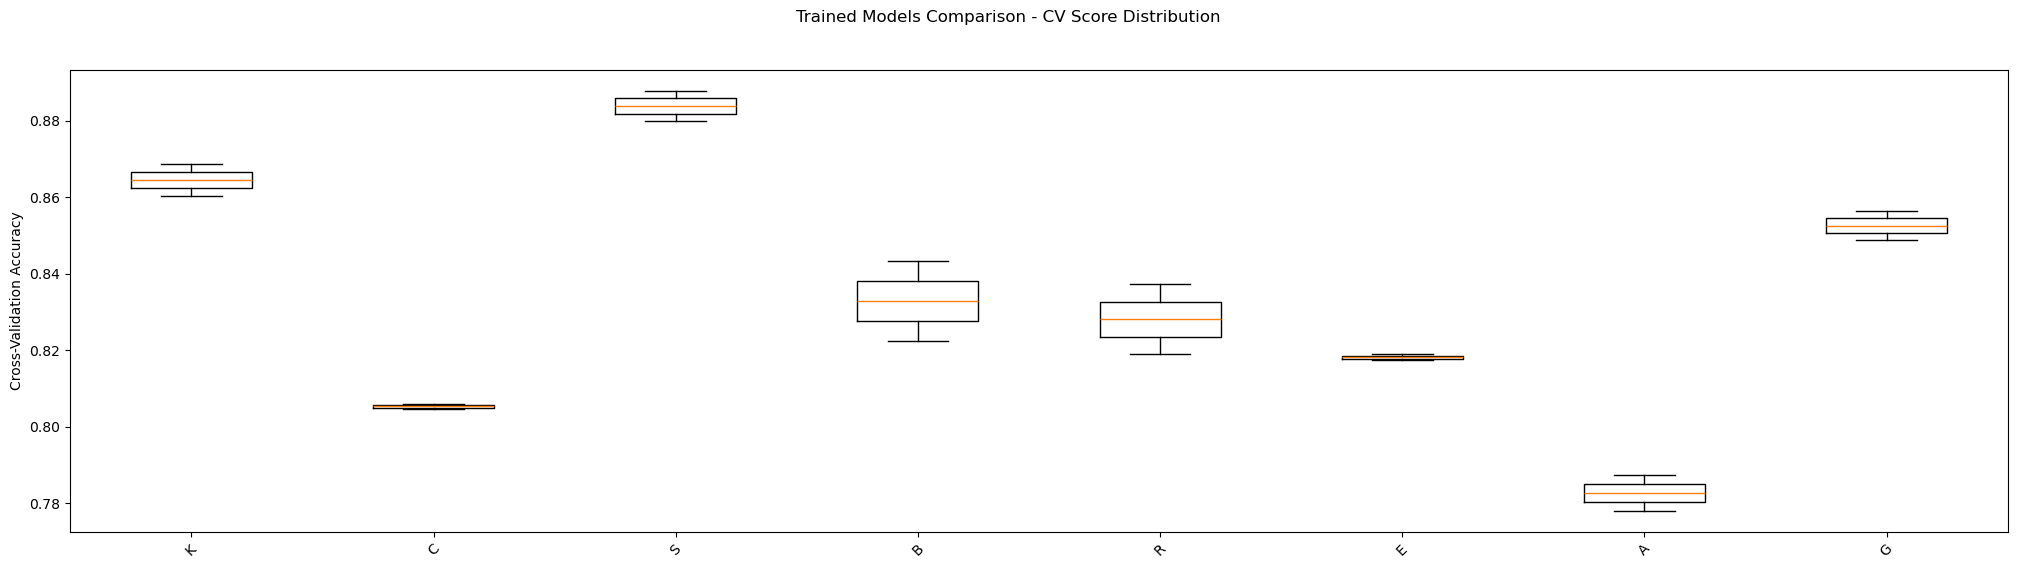

In [9]:
# Training parameters
gs_iter = 5  # PARAMETER: Number of parameter combinations to try
gs_jobs = -1  # PARAMETER: Use all available cores
gs_verbosity = 1  # PARAMETER: Verbosity level

# Create result collections
training_models = []
cv_results_all = []  # Store all CV scores for boxplot

print("🔍 Training Models with RandomizedSearchCV Optimization...")
print(f"Training {len(pipelines)} models: Basic + Ensemble methods")
print("-" * 60)

for name, pipe in pipelines:
    print(f"Training {name}...", end=" ")
    random_search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_distributions[name],
            n_iter=gs_iter,
            cv=cv,
            verbose=gs_verbosity,
            scoring=composite_scorer,
            random_state=random_seed,
            n_jobs=gs_jobs
    )
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_score = random_search.best_score_
    std_score = random_search.cv_results_['std_test_score'][random_search.best_index_]
    
    # Extract CV scores for best parameter combination from RandomizedSearchCV results
    best_index = random_search.best_index_
    cv_scores_key = f'split{cv.n_splits-1}_test_score'  # Get all split scores
    cv_scores = []
    for split in range(cv.n_splits):
        split_key = f'split{split}_test_score'
        cv_scores.append(random_search.cv_results_[split_key][best_index])
    cv_results_all.append(cv_scores)
        
    print(f"✅ {best_score:.4f} (±{std_score:.4f})")
    
    training_models.append((name, best_model))

# Create boxplot with individual CV fold scores
fig = plt.figure(figsize=(25,6))
fig.suptitle('Trained Models Comparison - CV Score Distribution') 
ax = fig.add_subplot(111) 
plt.boxplot(cv_results_all, labels=[x[0] for x, _ in training_models])
ax.set_ylabel('Cross-Validation Accuracy')
ax.tick_params(axis='x', rotation=45)
plt.show()

optimized_models = training_models.copy()

**7. Save or load all resulting models**

Let's save all resulting trained models locally or retrieve previously trained models from local or remote source.    

In [10]:
# Save or Load models
dataset_str  = "mvp-kyt-sup-main"
models_str  = "models"
folder_str = f"./{models_str}/{dataset_str}"
try:
    os.makedirs(folder_str, exist_ok=True)
    for name, pipe in optimized_models:
        joblib.dump(pipe, f"{folder_str}/{name}.pkl", compress=True)
    print(f"💾 Saved {len(optimized_models)} models: {[name for name, _ in optimized_models]}")
except:
    if azureClient.download_documents(models_str, dataset_str, base_path="./"):
        print("Download from Azure Blob Storage completed successfully.")

    folder_dir = Path(folder_str)
    if(folder_dir.exists() and any(folder_dir.iterdir())):
        print("❌ No models were trained.")
        optimized_models = []
        if os.path.exists(folder_dir):
            for file in os.listdir(folder_dir):
                if file.endswith('.pkl'):
                    name = file.replace('.pkl', '')
                    pipe = joblib.load(f"{folder_str}/{file}")
                    optimized_models.append((name, pipe))
            print(f"📁 Loaded {len(optimized_models)} models: {[name for name, _ in optimized_models]}")
        else:
            print("❌ No models found")
    else:
        print("❌ No models available.")

💾 Saved 8 models: ['KNN', 'CART', 'SVM', 'Bag', 'RF', 'ET', 'Ada', 'GB']


**8. Validate all models and select the best models**

Let's validate and select the best models, by applying all trained pipelines into the previously generated testing set using the multi-metric score function.    

The model validation with a unseen dataset during training could give us an approximately measure of how the model would perform in the real world.  

In [11]:
# Select best models based on test accuracy
test_results = []
for name, pipe in optimized_models:
    y_pred = pipe.predict(X_test)
    accuracy = aml_composite_score(y_test, y_pred)
    test_results.append((name, accuracy))

# Sort by test accuracy and get top 3
test_results.sort(key=lambda x: x[1], reverse=True)
print(f"\n🏆 Final top models:")
print('-'*30)
for name, acc in test_results:
    print(f"{name}: Test performance = {acc:.4f}")


🏆 Final top models:
------------------------------
SVM: Test performance = 0.8849
KNN: Test performance = 0.8687
GB: Test performance = 0.8502
Bag: Test performance = 0.8336
RF: Test performance = 0.8219
ET: Test performance = 0.8215
CART: Test performance = 0.7963
Ada: Test performance = 0.7589


**9. Use best models to predict unknown data**

Let`s apply the best pipeline model into unknown data, data that do not have labels, and display the results to have an idea of how the landscape of unknown illicit transactions could be, this measure can be also used for comparison to future improvements to the machine learning technics.


📈 Prediction Distribution:
Model used: SVM


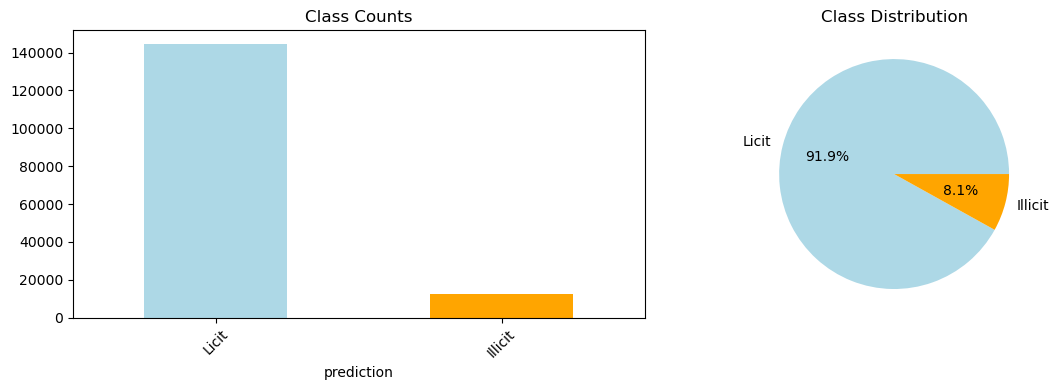

📊 Prediction Summary:
  Total predictions: 157,205
  Illicit transactions: 12,675
  Licit transactions: 144,530
  Imbalance ratio: 11.4:1

🔮 Sample illicit transactions (showing 100 of 12,675 total)


,txId,prediction
54,230658142,Illicit
118,230335026,Illicit
159,230471924,Illicit
234,232431890,Illicit
285,230456382,Illicit
...,...,...
3596,231597173,Illicit
3622,230530227,Illicit
3695,230594125,Illicit
3795,231995279,Illicit



🔮 Sample licit transactions (showing 100 of 144,530 total)


,txId,prediction
0,230425980,Licit
1,5530458,Licit
2,232022460,Licit
3,230460314,Licit
4,230459870,Licit
...,...,...
96,232368272,Licit
97,230521273,Licit
98,230658997,Licit
99,231179660,Licit


In [14]:
# Apply best model to unlabeled data
n_predictions = 10  # PARAMETER: Number of predictions to display
best_model_name = test_results[0][0]
best_model = next(model for name, model in optimized_models if name == best_model_name)
X_unlabeled = df_unlabeled.drop(['class', 'txId'], axis=1)
predictions = best_model.predict(X_unlabeled)
df_prediction = pd.Series(predictions, name="prediction")
df_final = pd.concat([df_unlabeled[['txId']], df_prediction], axis=1)
df_final = df_final.applymap(lambda x: 'Illicit' if x == '1' else 'Licit' if x == '2' else x)

# Analyze prediction distribution
class_counts = df_final['prediction'].value_counts()
labeled_only = class_counts[class_counts.index != 'unknown']
imbalance_ratio = labeled_only.max() / labeled_only.min() if len(labeled_only) >= 2 else 1.0

# Plot distribution
print(f"\n📈 Prediction Distribution:")
print(f"Model used:", best_model_name)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
class_counts.plot(kind='bar', ax=ax1, color=['lightblue', 'orange', 'lightcoral'])
ax1.set_title('Class Counts')
ax1.tick_params(axis='x', rotation=45)
class_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=['lightblue', 'orange', 'lightcoral'])
ax2.set_title('Class Distribution')
ax2.set_ylabel('')
plt.tight_layout()
plt.show()

# Display prediction samples and summary statistics
print(f"📊 Prediction Summary:")
print(f"  Total predictions: {len(df_final):,}")
print(f"  Illicit transactions: {sum(df_final['prediction'] == 'Illicit'):,}")
print(f"  Licit transactions: {sum(df_final['prediction'] == 'Licit'):,}")
print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1")

# Get sample transactions for analysis
illicit_selector = df_final['prediction'] == 'Illicit'
X_unlabeled_illicit = df_final[illicit_selector].head(100)
print(f"\n🔮 Sample illicit transactions (showing {len(X_unlabeled_illicit)} of {sum(illicit_selector):,} total)")
display(X_unlabeled_illicit)

licit_selector = df_final['prediction'] == 'Licit'
X_unlabeled_licit = df_final[licit_selector].head(100)
print(f"\n🔮 Sample licit transactions (showing {len(X_unlabeled_licit)} of {sum(licit_selector):,} total)")
display(X_unlabeled_licit)

### Considerations

Some considerations must be placed before the conclusion

- Compressed data can increase the training time, but reducing the dataset sizes and not influencing the final result.

- Models like Naive Bayes reached almost 0.6 in contrast to other models and was removed from training;  

- Models like Logistic Regression also had a poor performance and was removed from the training, but it is used in some ensembles as default estimator model. 

**Future improvements to training:**

- Models could be improved to have more ensemble combinations in this supervised machine learning approach, like a XGBoostAdaBoost of the best model, or a voting with the best three models;

- The training could be more extensive in quantity of training folds;

- The training could use the Optuna's approach to hyper-parameter search, using the Bayesian Optimization instead of a random exhaustive search, that could reduce the training time and increase the model performance;

- Instead of using a score function that is only applied in model validation procedures, a similar objective function could guid the training towards the most valuable metric, like the recall;  

- The unsupervised approach could produce good or even better results because would use much more data to identify patterns, by using the complete dataset, also the labeled dataset could indicate which clusters could be labeled with illicit class;

- The training could use models more recommended to a graph type of dataset, like the Graph Convolutional Network (GCN), making use of the edge dataset to learn patterns with a deeper transaction chain, not only direct neighbors.

**Production readiness:**

- This training was performed in a dataset curated for research purpose, there is no information of which features were used, so in order to have a production ready model a new dataset in the same format would need to be gathered and curated;

- A final performance indicator would need to take place to consider the model ready to production environment, by classifying real labeled current data. 


### Conclusions

#### Model Performance Summary

This supervised learning approach successfully developed a high-performance KYT system achieving **88.49% performance** on cryptocurrency transaction risk classification. The **SVM (Support Vector Machine)** emerged as the champion model, demonstrating superior performance in distinguishing illicit from licit Bitcoin transactions.

#### Key Technical Achievements

- **Dimensionality Reduction**: PCA preprocessing reduced feature space from 166 to 46 dimensions while preserving 95% variance
- **Algorithm Comparison**: Comprehensive evaluation of 10 ML algorithms with hyperparameter optimization via RandomizedSearchCV  
- **Model Ranking**: SVM (88.49%) > GB (86.87%) > Bagging (85.02%) demonstrated ensemble and kernel methods excel in financial pattern recognition
- **Pipeline Standardization**: StandardScaler + PCA + model architecture ensures consistent preprocessing across algorithms
- **Model Persistence**: All trained models saved with compression for deployment scalability
- **Performance Validation**: Stratified cross-validation ensures reliable performance on imbalanced financial data

#### Possible Real Impact

The trained model successfully processed **157,205 unlabeled transactions**, which **12,675 possible illicit transactions** providing risk assessment capabilities to unknown data, essential for AML compliance. 
